# Light Curve Classifier
***

## Learning Goals
By the end of this tutorial, you will be able to:
- do some basic data cleaning and filtering to prepare the data for the ML algorithms
- work with Pandas data frames as a way of storing time domain datasets
- use sktime algorithms to train a classifier and predict values on a test dataset

## Introduction
This notebook takes output of a previous demo notebook which generates light curves from archival data, does data prep, and runs the light curves through multiple [`sktime`](https://www.sktime.net/en/stable/) classifiers.  The goal of the classifiers is to be able to differentiate changing look active galactic nucleii (CLAGN) from an SDSS quasar sample based on multiband light curves.  CLAGN are quite interested objects in that they appear to change state, but only a few hundred are currently known, and finding them is quite expensive requiring spectroscopic follow up.  Being able to identify CLAGN in existing large samples would allow us to identify a statisitcal sample from which we could better understand the physics of what is occuring in these systems.

The challenges of this time-domain dataset are:
1. Multi-variate = There are multiple bands of observations per target (13+)
2. Unequal length = Each band has a light curve with different sampling than other bands
3. Missing data = Not each object has all observations in all bands

We choose to use a Pandas multiindex dataframe to store and work with the data because it fulfills these requirements:
1. It can handle the above challenges of a dataset = multi-variate, unqueal length with missing data.
2. Multiple targets (multiple rows)
3. Pandas has some built in understanding of time units
4. Can be scaled up to big data numbers of rows (altough we don't push to out of memory structures in this use case)
5. Pandas is user friendly


## Input
Light curve parquet file of multiband light curves from the mulitband_lc.ipynb demo notebook.  The format of the light curves is a Pandas multiindex data frame

A useful reference for what sktime expects as input to its ML algorithms: https://github.com/sktime/sktime/blob/main/examples/AA_datatypes_and_datasets.ipynb

## Output
Trained classifiers as well as estimates of their accuracy and plots of confusion matrices

## Imports
- `pandas` to work with light curve data structure
- `numpy` for numerical calculations
- `matplotlib` for plotting
- `sys` for paths
- `astropy` to work with coordinates/units and data structures
- `tqdm` for showing progress meter
- `sktime` ML algorithms specifically for time-domain data
- `sklearn` general use ML algorthims with easy to use interface

## Authors

## Acknowledgements

In [1]:
#ensure all dependencies are installed
!pip install -r requirements-lc_classifier.txt


[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.time import Time
from google_drive_downloader import GoogleDriveDownloader as gdd
from scipy.stats import sigmaclip

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsRegressor

from sktime.classification.deep_learning import CNNClassifier
from sktime.classification.dictionary_based import IndividualTDE
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.dummy import DummyClassifier
from sktime.classification.ensemble import WeightedEnsembleClassifier
from sktime.classification.feature_based import Catch22Classifier, RandomIntervalClassifier
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.kernel_based import Arsenal, RocketClassifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.registry import all_estimators, all_tags
from tqdm import tqdm

# local code imports
sys.path.append('code_src/')
from fluxconversions import mjd_to_jd

/Users/bsipocz/.pyenv/versions/3.11.0/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## 1. Read in a dataset of archival light curves

In [3]:
#access structure of light curves made in the light curve notebook
# has CLAGN & SDSS small sample, all bands
#https://drive.google.com/file/d/13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz/view?usp=share_link

gdd.download_file_from_google_drive(file_id='13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz',
                                    dest_path='./data/df_lc_458sample.parquet',
                                    unzip=True)

df_lc = pd.read_parquet("./data/df_lc_458sample.parquet")

#get rid of indices set in the light curve code and reset them as needed before sktime algorithms
df_lc = df_lc.reset_index()  

## 2. Data Prep
This dataset needs significant work before it can be fed into a ML algorithm

In [4]:
#what does the dataset look like anyway?
df_lc

,objectid,label,band,time,flux,err
0,112,Lopez-Navas 22,FERMIGTRIG,56371.813768,0.100000,0.100000
1,218,SDSS,FERMIGTRIG,59568.171278,0.100000,0.100000
2,395,SDSS,FERMIGTRIG,54699.331556,0.100000,0.100000
3,414,SDSS,FERMIGTRIG,56369.455916,0.100000,0.100000
4,434,SDSS,FERMIGTRIG,58941.402522,0.100000,0.100000
...,...,...,...,...,...,...
426627,183,SDSS,w2,55230.410156,6.717855,0.019561
426628,183,SDSS,w2,57054.886719,6.715584,0.023281
426629,183,SDSS,w2,57247.308594,7.572342,0.024136
426630,183,SDSS,w2,57977.214844,7.876407,0.023734


### 2.1 Remove bands with not enough data
For this use case of CLAGN classification, we don't need to include some of the bands
that are known to be sparse.

In [5]:
##what are the unique set of bands included in our light curves
df_lc.band.unique()

array(['FERMIGTRIG', 'IceCube', 'zg', 'zr', 'zi', 'panstarrs i',
       'panstarrs y', 'panstarrs z', 'panstarrs g', 'panstarrs r',
       'Gaia g', 'Gaia bp', 'Gaia rp', 'K2', 'TESS', 'w1', 'w2'],
      dtype=object)

In [6]:
# get rid of some of the bands that don't have enough data for all the sources

bands_to_drop = ["IceCube", "TESS", "FERMIGTRIG", "K2"]
df_lc = df_lc[~df_lc["band"].isin(bands_to_drop)]

### 2.2 Combine Labels for a Simpler Classification
All CLAGN start in the dataset as having labels based on their discovery paper.  Because we want one sample with all known CLAGN, change those discoery names to be simply "CLAGN" for all CLAGN, regardless of origin

In [7]:
df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Yang 18', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lyu 21', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Hon 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Sheng 20', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('MacLeod 19', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Green 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lopez-Navas 22', 'CLAGN')


/var/folders/9s/070g0pd502q70k3gffpxv8km0000gq/T/ipykernel_73745/669698915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
/var/folders/9s/070g0pd502q70k3gffpxv8km0000gq/T/ipykernel_73745/669698915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
/var/folders/9s/070g0pd502q70k3gffpxv8km0000gq/T/ipykernel_73745/669698915.py:3: SettingWithCopyWarning: 
A value is trying to be 

/var/folders/9s/070g0pd502q70k3gffpxv8km0000gq/T/ipykernel_73745/669698915.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('Sheng 20', 'CLAGN')
/var/folders/9s/070g0pd502q70k3gffpxv8km0000gq/T/ipykernel_73745/669698915.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lc['label'] = df_lc.label.str.replace('MacLeod 19', 'CLAGN')
/var/folders/9s/070g0pd502q70k3gffpxv8km0000gq/T/ipykernel_73745/669698915.py:8: SettingWithCopyWarning: 
A value is trying to be se

### 2.3 Remove "bad"  data
"bad" includes:
- errant values
- NaNs
- zero flux
- outliers in uncertainty
- objects with not enough flux measurements to make a good light curve
- objects with no measurements in WISE W1 band

In [8]:
#find and drop bad rows

#one panstarrs z has a crazy err value of -999000, definitely don't want to include that one
querystring = 'err < -100'
df_lc = df_lc.drop(df_lc.query(querystring).index)

#drop rows which have Nans
df_lc.dropna(inplace = True, axis = 0)

#drop ~8 rows with zero flux
#We are going to define zero flux later to be missing data, but not sure what these are
querystring = 'flux < 0.000001'
df_lc = df_lc.drop(df_lc.query(querystring).index)


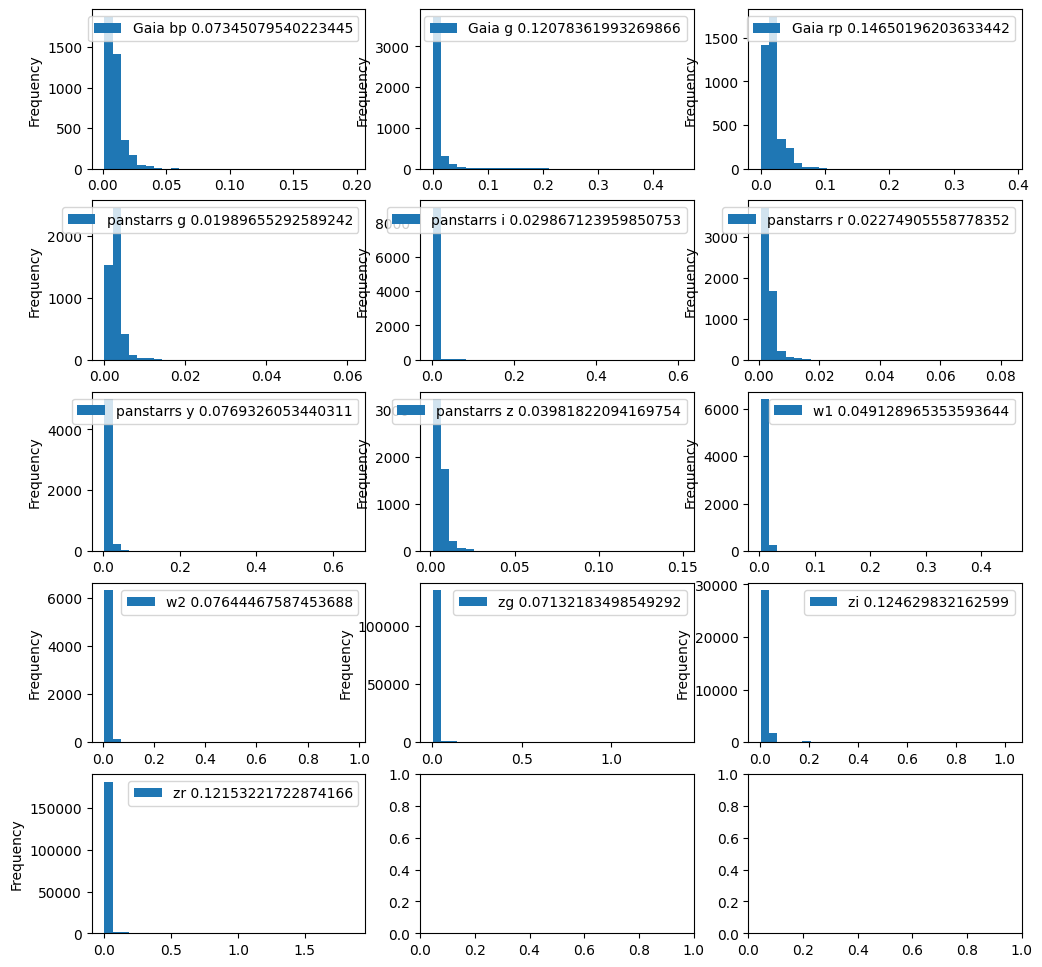

In [9]:
#consider Removing all rows with uncertainties well outside of a normal distribution
#plot histograms to see what these distributions look like
#This is a tricky job because we want to keep astrophysical outliers of variable objects, but 
#remove instrumental noise and CR (ground based)

#keep track of how many rows this removes
start_len = len(df_lc)

#setup to collect the outlier thresholds per band to later reject
nsigmaonmean= {}

#what value of sigma are we going to consider is an outlier?
sigmaclip_value = 10.0

#create the figure and axes
fig, axs = plt.subplots(5, 3, figsize = (12, 12))

# unpack all the axes subplots
axe = axs.ravel()

#for each band
for count, (bandname, singleband) in enumerate(df_lc.groupby("band")):
    
    #use scipy sigmaclip to iteratively determine sigma on the dataset
    clippedarr, lower, upper = sigmaclip(singleband.err, low = sigmaclip_value, high = sigmaclip_value)
    
    #store this value for later
    nsigmaonmean[bandname] = upper
    
    #plot distributions and print stddev
    singleband.err.plot(kind = 'hist', bins = 30, subplots =True, ax = axe[count],label = bandname+' '+str(upper), legend=True)

In [10]:
#remove data that are outside the sigmaclip_value
for bandname, cut in nsigmaonmean.items():
    querystring = f'band == {bandname!r} & err > {cut}'
    df_lc = df_lc.drop(df_lc.query(querystring).index)

In [11]:
#how much data did we remove with this sigma clipping?
#This should inform our choice of sigmaclip_value.

end_len = len(df_lc)
fraction = (start_len - end_len) / start_len
print(f"This {sigmaclip_value} sigma clipping removed {fraction}% of the rows in df_lc")

This 10.0 sigma clipping removed 0.01239000995250949% of the rows in df_lc


In [12]:
#Remove objects which do not have fluxes measured in the band with which we want to normalize
#which band has the most data?

#Later in the code we will need to noramalize fluxes by one of the bands
#This cell aims to figure out which band has the most data 
#this needs to be run before we go and fill in missing data

#how many objects are there total?
total_objectids = df_lc.groupby( "objectid").ngroups

#how many objects have at least 1 flux in each of the band?
for band, df_lc_band in df_lc.groupby( "band"):
    total_band = df_lc_band.groupby("objectid").ngroups
    print(total_band/total_objectids, " have ", band, " fluxes" )


0.8713968957871396  have  Gaia bp  fluxes
0.8758314855875832  have  Gaia g  fluxes
0.8713968957871396  have  Gaia rp  fluxes
0.9068736141906873  have  panstarrs g  fluxes
0.9312638580931264  have  panstarrs i  fluxes
0.9223946784922394  have  panstarrs r  fluxes
0.8913525498891353  have  panstarrs y  fluxes
0.926829268292683  have  panstarrs z  fluxes
0.9667405764966741  have  w1  fluxes
0.9512195121951219  have  w2  fluxes
0.8625277161862528  have  zg  fluxes
0.7139689578713969  have  zi  fluxes
0.9002217294900222  have  zr  fluxes


In [13]:
#this argues for normalizing by w1 fluxes (later)
#We will therefore need to get rid of the 4% of light curves which do not have W1 data
#as there will be nothing to normalize those light curves with and we don't want to 
#have un-normalized data or data that has been normalized by a different band.  

#keep track of how many get dropped
dropcount = 0

#for each object
for oid , singleoid in df_lc.groupby("objectid"):
    #what bands does that object have
    bandname = singleoid.band.unique().tolist()
    
    #if it doesn't have W1:
    if 'w1' not in bandname:
        #delete this oid from the dataframe of light curves
        indexoid = df_lc[ (df_lc['objectid'] == oid)].index
        df_lc.drop(indexoid , inplace=True)
        
        #keep track of how many are being deleted
        dropcount = dropcount + 1
        
        
print( dropcount, "objects do not have W1 fluxes and were removed")

15 objects do not have W1 fluxes and were removed


### 2.4 Incomplete Data

Some objects have only a few datapoints.  Three data points is not large enough for KNN interpolation, so we will consider any array with fewer than 4 photometry points to be incomplete data.

Another way of saying this is that we choose to remove those light curves with 3 or fewer data points.

In [14]:
#Define what the threshold is for too few datapoints.
thresh_too_few = 3

#how many groups do we have before we start
print(df_lc.groupby(["band", "objectid"]).ngroups, "n groups before")

#use pandas .filter to remove small groups
df_lc = df_lc.groupby(["band", "objectid"]).filter(lambda x: len(x) > thresh_too_few)

#how many groups do we have after culling?
print(df_lc.groupby(["band", "objectid"]).ngroups, "n groups after")

#currently this seems like a lot of groups because we still have the gaia single photometry points for many objects


5117 n groups before
4160 n groups after


### 2.5 Missing Data
Some objects do not have light curves in all bands.  Some ML algorithms can handle mising data, but not all, so it would be useful to handle this missing data up front.

We will add light curves with zero flux and err values for the missing data.  SKtime does not like NaNs, so we chose zeros.

In [15]:
def make_zero_lc(oid, band, label):
    #randomly choose some times during the WISE survey
    #these will all get fleshed out in the section on making uniform length time arrays
    #so the specifics are not important now
    timelist = [55230.0,57054.0, 57247.0, 57977.0, 58707.0]  
    
    #make a dictionary to hold the light curve
    zerosingle = {"objectid": oid, "label": label, "band": band, "time": timelist, 
                  "flux": np.zeros(len(timelist)), "err":np.zeros(len(timelist))}
    
    return zerosingle

In [16]:
#for the case where there is no photometry in a band:
#make light curves with flux, err set to zeros

#what is the full set of unique band names?
full_bandname = df_lc.band.unique()

#setup a list to store empty light curves
zerosingle_list = [] 

#for each object in each band
for oid , singleoid in df_lc.groupby("objectid"):
                                  
    #this is the list of bandnames for that object                                
    oid_bandname = singleoid.band.unique()
    
    #figure out which bands are missing
    missing = list(set(full_bandname).difference(oid_bandname))
    
    #if it is not the complete list, ie some bandnames are missing:                            
    if len(missing) > 0:
    
        #make new dataframe for this object with zero flux and err values
        for band in missing:
            label = str(singleoid.label.unique().squeeze())
            zerosingle = make_zero_lc(oid, band, label)
            #keep track of these empty light curces in a list
            zerosingle_list.append(zerosingle)

            
#turn the empty light curves into a dataframe
df_empty = pd.DataFrame(zerosingle_list)
# df_empty has one row per dict. time,flux, and err columns store arrays.
# "explode" the dataframe to get one row per light curve point. time, flux, and err columns will now store floats.
df_empty = df_empty.explode(["time", "flux","err"], ignore_index=True)


#now put the empty light curves back together with the main light curve dataframe
df_lc = pd.concat([df_lc, df_empty])

### 2.5  Make all objects and bands have identical time arrays (uniform length and spacing)

It is very hard to find time-domain ML algorithms which can handle non uniform length datasets. Therefore we make them uniform using Pandas [reindex](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html) which fills in the uniform length arrays with values according to the method chosen by the user.  We implement a nearest neighbor to fill the arrays.  

try a sklearn regressor to fit the shape of the light curve and do interpolation

Potential other options for uniformizing the time series dataset:
- pandas.dataframe.interpolate with many methods

In [17]:
#what does it look like?
df_lc

,objectid,label,band,time,flux,err
1379,92,CLAGN,zg,58202.309236,0.736736,0.010347
1380,92,CLAGN,zg,58202.31456,0.730595,0.01029
1381,92,CLAGN,zg,58205.302651,0.658396,0.009634
1382,92,CLAGN,zg,58205.320949,0.681111,0.00984
1383,92,CLAGN,zg,58208.357257,0.589205,0.009014
...,...,...,...,...,...,...
7405,457,SDSS,Gaia rp,55230.0,0.0,0.0
7406,457,SDSS,Gaia rp,57054.0,0.0,0.0
7407,457,SDSS,Gaia rp,57247.0,0.0,0.0
7408,457,SDSS,Gaia rp,57977.0,0.0,0.0


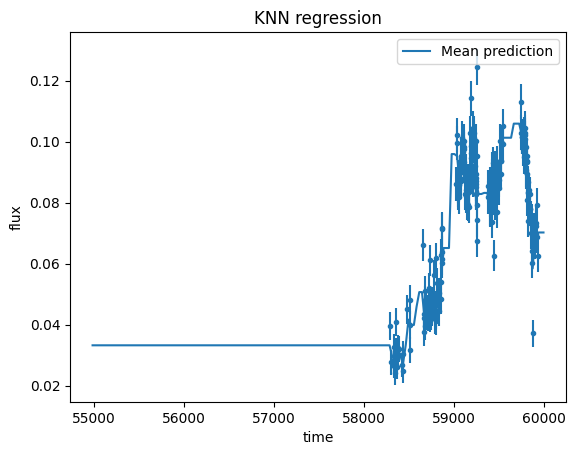

In [18]:
#this cell takes 13seconds to run on the sample of 458 sources

#change this to change the frequency of the time array
final_freq_int = 30  #this is the timescale of interpolation in units of days

#make a time array with the minimum and maximum of all light curves in the sample
x_interpol = np.arange(df_lc.time.min(), df_lc.time.max(), final_freq_int)
x_interpol = x_interpol.reshape(-1, 1) # needed for sklearn
lc_interpol = []  # list to store interpolated light curves

#look at each object in each band
for (band,oid) , singleband_oid in df_lc.groupby(["band", "objectid"]):
    #singleband_oid is now a dataframe with just one object and one band
    X = np.array(singleband_oid["time"]).reshape(-1, 1)
    y = np.array(singleband_oid["flux"])
    dy = np.array(singleband_oid["err"])
    
    #kernel = 1.0 * RBF(length_scale=30)
    #gp = GaussianProcessRegressor(kernel=kernel, alpha=dy**2, normalize_y = False)
    #gp.fit(X, y)
    #mean_prediction,std_prediction = gp.predict(x_interpol, return_std=True)

    #try KNN
    KNN = KNeighborsRegressor(n_neighbors = 3)
    KNN.fit(X, y)
    mean_prediction = KNN.predict(x_interpol)
        
    #KNN doesnt output an uncertainty array, so make our own:
    #an array of the same length as mean_prediction
    #having values equal to the mean of the original uncertainty array
    err = np.full_like(mean_prediction, singleband_oid.err.mean())  
        
    #get these values into the dataframe
    # append the results as a dict. the list will be converted to a dataframe later.
    lc_interpol.append(
        {"objectid": oid, "label": str(singleband_oid.label.unique().squeeze()), "band": band, "time": x_interpol.reshape(-1), 
         "flux": mean_prediction, "err": err}
    )
    
        
    #se what this looks like on just a single light curve for now
    if (band == 'zr') and (oid == 9) :  
        #see if this looks reasonable
        plt.errorbar(X,y,dy,linestyle="None",color="tab:blue",marker=".")
        plt.plot(x_interpol, mean_prediction, label="Mean prediction")
        #plt.fill_between(
        #    x_interpol.ravel(),
        #    mean_prediction - 1.96 * std_prediction,
        #    mean_prediction + 1.96 * std_prediction,
        #    color="tab:orange",
        #    alpha=0.5,
        #    label=r"95% confidence interval",
        #)
        plt.legend()
        plt.xlabel("time")
        plt.ylabel("flux")
        _ = plt.title("KNN regression")
        
        
# create a dataframe of the interpolated light curves
df_interpol = pd.DataFrame(lc_interpol)
# df_lc_interpol has one row per dict in lc_interpol. time and flux columns store arrays.
# "explode" the dataframe to get one row per light curve point. time and flux columns will now store floats.
df_lc = df_interpol.explode(["time", "flux","err"], ignore_index=True)

#somehow data types for some columns are coming in as 'object' which sktime doesn't like
#instead make them numeric data types
cols = ["time", "flux", "err"]
df_lc[cols] = df_lc[cols].apply(pd.to_numeric, errors='coerce')

### 2.6  Restructure dataframe in format expected by sktime
- Make columns have band names in them and then remove band from the index
- pivot the dataframe so that SKTIME understands its format

In [19]:
df_lc

,objectid,label,band,time,flux,err
0,0,CLAGN,Gaia bp,54985.275796,0.000000,0.000000
1,0,CLAGN,Gaia bp,55015.275796,0.000000,0.000000
2,0,CLAGN,Gaia bp,55045.275796,0.000000,0.000000
3,0,CLAGN,Gaia bp,55075.275796,0.000000,0.000000
4,0,CLAGN,Gaia bp,55105.275796,0.000000,0.000000
...,...,...,...,...,...,...
947851,457,SDSS,zr,59875.275796,0.830931,0.013213
947852,457,SDSS,zr,59905.275796,0.830027,0.013213
947853,457,SDSS,zr,59935.275796,0.741216,0.013213
947854,457,SDSS,zr,59965.275796,0.813474,0.013213


In [20]:
#keep some columns out of the mix when doing the pivot by bandname
#set them as indices and they won't get pivoted into
df_lc = df_lc.set_index(["objectid", "label", "time"])

#attach bandname to all the fluxes and uncertainties
df_lc = df_lc.pivot(columns = "band")

#rename the columns
df_lc.columns = ["_".join(col) for col in df_lc.columns.values]

#many of these flux columns still have a space in them from the bandnames, 
#convert that space to underscore
df_lc.columns = df_lc.columns.str.replace(' ', '_') 

#and get rid of that index to cleanup
df_lc = df_lc.reset_index()  

In [21]:
#look at a single object to see what this array looks like
ob_of_interest = 4
singleob = df_lc[df_lc['objectid'] == ob_of_interest]
singleob

,objectid,label,time,flux_Gaia_bp,flux_Gaia_g,flux_Gaia_rp,flux_panstarrs_g,flux_panstarrs_i,flux_panstarrs_r,flux_panstarrs_y,...,err_panstarrs_g,err_panstarrs_i,err_panstarrs_r,err_panstarrs_y,err_panstarrs_z,err_w1,err_w2,err_zg,err_zi,err_zr
672,4,CLAGN,54985.275796,0.075968,0.058815,0.173102,0.032355,0.085156,0.053759,0.159406,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625
673,4,CLAGN,55015.275796,0.075968,0.058815,0.173102,0.032355,0.085156,0.053759,0.159406,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625
674,4,CLAGN,55045.275796,0.075968,0.058815,0.173102,0.032355,0.085156,0.053759,0.159406,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625
675,4,CLAGN,55075.275796,0.075968,0.058815,0.173102,0.032355,0.085156,0.053759,0.159406,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625
676,4,CLAGN,55105.275796,0.075968,0.058815,0.173102,0.032355,0.085156,0.053759,0.159406,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,4,CLAGN,59875.275796,0.083895,0.082534,0.190779,0.028789,0.142836,0.068780,0.118329,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625
836,4,CLAGN,59905.275796,0.083895,0.082534,0.190779,0.028789,0.142836,0.068780,0.118329,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625
837,4,CLAGN,59935.275796,0.083895,0.082534,0.190779,0.028789,0.142836,0.068780,0.118329,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625
838,4,CLAGN,59965.275796,0.083895,0.082534,0.190779,0.028789,0.142836,0.068780,0.118329,...,0.001867,0.002682,0.0018,0.011534,0.003545,0.006379,0.014269,0.00415,0.007337,0.005625


### 2.7 Normalize 
- this is normalizing across all bands
- think this is the right place to do this, rather than interpolate over time 
    so that the final light curves are normalized since that is the chunk of information 
    which goes into the ML algorithms.
- chose max and not median or mean because there are some objects where the median flux = 0.0
    - if we did this before the interpolating, the median might be a non-zero value
- normalizing is required so that the CLAGN and it's comparison SDSS sample don't have different flux levels.


Idea here is that we normalize across each object.  So the algorithms will know, for example, that within one object W1 will be brighter than ZTF bands but from one object to the next, it will not know that one is brighter than the other.

In [22]:
# make a new column with max_r_flux for each objectid
df_lc['max_W1'] = df_lc.groupby('objectid', sort=False)["flux_w1"].transform('max')

In [23]:
#figure out which columns in the dataframe are flux columns
flux_cols = [col for col in df_lc.columns if 'flux' in col]

# make new normalized flux columns for all fluxes
df_lc[flux_cols] = df_lc[flux_cols].div(df_lc['max_W1'], axis=0)

### 2.8 Make datetime time column
https://docs.python.org/3/library/datetime.html#module-datetime

SKTime wants a datetime column

In [24]:
#need to convert df_lc time into datetime
mjd = df_lc.time

#convert to JD
jd = mjd_to_jd(mjd)

#convert to individual components
t = Time(jd, format = 'jd' )

#t.datetime is now an array of type datetime
#make it a column in the dataframe
df_lc['datetime'] = t.datetime


### 2.9 Save this dataframe

In [25]:
#save this dataframe to use for the ML below so we don't have to make it every time
parquet_savename = 'output/df_lc_ML.parquet'
df_lc.to_parquet(parquet_savename)
#print("file saved!")

### 2.10 make into multi-index which is what SKTime expects as input

In [26]:
df_lc = df_lc.set_index(["objectid", "label", "datetime"])

## 3. Prep for ML algorithms in sktime

In [27]:
# could load a previously saved file in order to plot
#parquet_loadname = 'output/df_lc_ML.parquet'
#df_lc = MultiIndexDFObject()
#df_lc.data = pd.read_parquet(parquet_loadname)
#print("file loaded!")

### 3.0 Consider data augmentation

1. https://arxiv.org/pdf/1811.08295.pdf which has the following github

    - https://github.com/gioramponi/GAN_Time_Series/tree/master
    - not easily usable
2. https://arxiv.org/pdf/2205.06758.pdf

3. ChatGPT - give multiindex df function and it will give a starting point for augmenting


Worried that augmenting noisy data just makes more noise

### 3.1 Train test split 
- Because thre are uneven numbers of each type (many more SDSS than CLAGN), we want to make sure to stratify evenly by type
- Random split

In [28]:
df_lc

time  flux_Gaia_bp  \
objectid label datetime                                                 
0        CLAGN 2009-06-03 06:37:08.765742  54985.275796           0.0   
               2009-07-03 06:37:08.765742  55015.275796           0.0   
               2009-08-02 06:37:08.765742  55045.275796           0.0   
               2009-09-01 06:37:08.765742  55075.275796           0.0   
               2009-10-01 06:37:08.765742  55105.275796           0.0   
...                                                 ...           ...   
457      SDSS  2022-10-23 06:37:08.765742  59875.275796           0.0   
               2022-11-22 06:37:08.765742  59905.275796           0.0   
               2022-12-22 06:37:08.765742  59935.275796           0.0   
               2023-01-21 06:37:08.765742  59965.275796           0.0   
               2023-02-20 06:37:08.765742  59995.275796           0.0   

                                           flux_Gaia_g  flux_Gaia_rp  \
objectid label datetime                                                
0        CLAGN 2009-06-03 06:37:08.765742          0.0           0.0   
               2009-07-03 06:37:08.765742          0.0           0.0   
               2009-08-02 06:37:08.765742          0.0           0.0   
               2009-09-01 06:37:08.765742          0.0           0.0   
               2009-10-01 06:37:08.765742          0.0           0.0   
...                                                ...           ...   
457      SDSS  2022-10-23 06:37:08.765742          0.0           0.0   
               2022-11-22 06:37:08.765742          0.0           0.0   
               2022-12-22 06:37:08.765742          0.0           0.0   
               2023-01-21 06:37:08.765742          0.0           0.0   
               2023-02-20 06:37:08.765742          0.0           0.0   

                                           flux_panstarrs_g  flux_panstarrs_i  \
objectid label datetime                                                         
0        CLAGN 2009-06-03 06:37:08.765742          0.137015          0.323656   
               2009-07-03 06:37:08.765742          0.137015          0.323656   
               2009-08-02 06:37:08.765742          0.137015          0.323656   
               2009-09-01 06:37:08.765742          0.137015          0.323656   
               2009-10-01 06:37:08.765742          0.137015          0.323656   
...                                                     ...               ...   
457      SDSS  2022-10-23 06:37:08.765742          0.115842          0.404488   
               2022-11-22 06:37:08.765742          0.115842          0.404488   
               2022-12-22 06:37:08.765742          0.115842          0.404488   
               2023-01-21 06:37:08.765742          0.115842          0.404488   
               2023-02-20 06:37:08.765742          0.115842          0.404488   

                                           flux_panstarrs_r  flux_panstarrs_y  \
objectid label datetime                                                         
0        CLAGN 2009-06-03 06:37:08.765742          0.261700          0.450450   
               2009-07-03 06:37:08.765742          0.261700          0.450450   
               2009-08-02 06:37:08.765742          0.261700          0.450450   
               2009-09-01 06:37:08.765742          0.261700          0.450450   
               2009-10-01 06:37:08.765742          0.261700          0.450450   
...                                                     ...               ...   
457      SDSS  2022-10-23 06:37:08.765742          0.214667          0.384747   
               2022-11-22 06:37:08.765742          0.214667          0.384747   
               2022-12-22 06:37:08.765742          0.214667          0.384747   
               2023-01-21 06:37:08.765742          0.214667          0.384747   
               2023-02-20 06:37:08.765742          0.214667          0.384747   

                                           flux_panstarr

In [29]:
#y is defined to be the labels
y = df_lc.droplevel('datetime').index.unique().get_level_values('label').to_series()

#want a stratified split based on label
test_size = 0.25
train_ix, test_ix = train_test_split(df_lc.index.levels[0], stratify = y, shuffle = True, random_state = 43, test_size = test_size)

train_df = df_lc.loc[train_ix]  
test_df = df_lc.loc[test_ix]   

/Users/bsipocz/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bsipocz/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


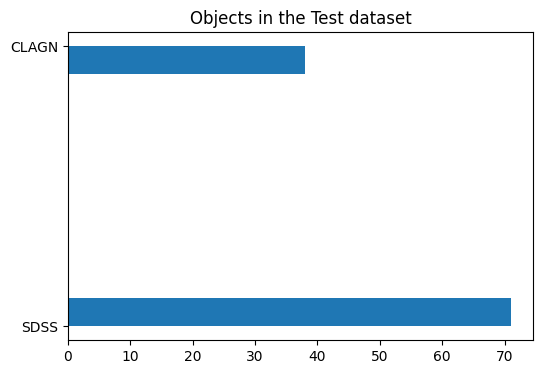

In [30]:
#plot to show how many of each type of object in the test dataset

plt.figure(figsize=(6,4))
plt.title("Objects in the Test dataset")
h = plt.hist(test_df.droplevel('datetime').index.unique().get_level_values('label').to_series(),histtype='stepfilled',orientation='horizontal')

In [31]:
#divide the dataframe into X and y for ML algorithms 

#X is the multiindex light curve without the labels
X_train  = train_df.droplevel('label')
X_test = test_df.droplevel('label')

#y are the labels, should be a series 
y_train = train_df.droplevel('datetime').index.unique().get_level_values('label').to_series()
y_test = test_df.droplevel('datetime').index.unique().get_level_values('label').to_series()


### 3.2 Check that the data types are ok for sktime

In [32]:
#ask sktime if it likes the data type of X_train
from sktime.datatypes import check_is_mtype

check_is_mtype(X_train, mtype="pd-multiindex", scitype="Panel", return_metadata=True)
#check_is_mtype(X_test, mtype="pd-multiindex", scitype="Panel", return_metadata=True)

#This test needs to pass in order for sktime to run

/Users/bsipocz/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sktime/datatypes/_panel/_check.py:270: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  metadata["is_equally_spaced"] = all(


(True,
 None,
 {'is_univariate': False,
  'is_empty': False,
  'has_nans': True,
  'n_instances': 325,
  'is_one_series': False,
  'is_equal_length': True,
  'is_equally_spaced': True,
  'n_panels': 1,
  'is_one_panel': True,
  'mtype': 'pd-multiindex',
  'scitype': 'Panel'})

## 4. Run Machine Learning Algorithms on the light curves

We choose to use [sktime](https://www.sktime.net/en/stable/index.html) algorithms beacuse it is a library of many algorithms specifically tailored to time series datasets.  It is based on the sklearn library so syntax is familiar to many users.

Types of classifiers are listed [here](https://www.sktime.net/en/stable/api_reference/classification.html).

This notebook will invert the actual workflow and show you a single example of the algorithm which best fits the data and has the most accurate classifier. Then it will show how to write a for loop over a bunch of classifiers before narrowing it down to the most accurate.

In [33]:
#what is the list of all possible classifiers that work with multivariate data
#all_tags(estimator_types = 'classifier')
classifiers = all_estimators("classifier", filter_tags={'capability:multivariate':True})
classifiers

[('Arsenal', sktime.classification.kernel_based._arsenal.Arsenal),
 ('BaggingClassifier',
  sktime.classification.ensemble._bagging.BaggingClassifier),
 ('CNNClassifier', sktime.classification.deep_learning.cnn.CNNClassifier),
 ('CanonicalIntervalForest',
  sktime.classification.interval_based._cif.CanonicalIntervalForest),
 ('Catch22Classifier',
  sktime.classification.feature_based._catch22_classifier.Catch22Classifier),
 ('ColumnEnsembleClassifier',
  sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier),
 ('DrCIF', sktime.classification.interval_based._drcif.DrCIF),
 ('DummyClassifier', sktime.classification.dummy._dummy.DummyClassifier),
 ('FCNClassifier', sktime.classification.deep_learning.fcn.FCNClassifier),
 ('FreshPRINCE',
  sktime.classification.feature_based._fresh_prince.FreshPRINCE),
 ('HIVECOTEV2', sktime.classification.hybrid._hivecote_v2.HIVECOTEV2),
 ('InceptionTimeClassifier',
  sktime.classification.deep_learning.inceptiontime.InceptionTimeClassif

### 4.1 The Most Accurate Classifier
See section 4.2 for how we landed with this algorithm

In [34]:
%%time
#looks like RandomIntervalClassifier is performing the best for the CLAGN (not for the SDSS)

#setup the classifier
clf = RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43)

#fit the classifier on the training dataset
clf.fit(X_train, y_train)

#make predictions on the test dataset using the trained model 
y_pred = clf.predict(X_test)

print(f"Accuracy of Random Interval Classifier: {accuracy_score(y_test, y_pred)}\n", flush=True)

#plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
    
plt.show()

ValueError: Data seen by RandomIntervalClassifier instance has missing values, but this RandomIntervalClassifier instance cannot handle missing values. Calls with missing values may result in error or unreliable results.

### 4.2 Loop over a bunch of classifiers

Our method is to do a cursory check of a bunch of classifiers and then later drill down deeper on anything with good initial results.  We choose to run a loop over ~10 classifiers that seem promising and check the accuracy scores for each one.  Any classifier with a promising accuracy score could then be followed up with detailed hyperparameter tuning, or potentially with considering other classifiers in that same type.

In [35]:
%%time
#which classifiers are we interestd in
#roughly one from each type of classifier

names = ["Arsenal",                     #kernel based
        "RocektClassifier",             #kernel based
        "CanonicalIntervalForest",      #interval based
        "HIVECOTEV2",                   #hybrid
#        "CNNClassifier",               #Deep Learning  - **requires tensorflow which is giving import errors
#        "WeightedEnsembleClassifier",   #Ensemble - **maybe use in the future if we find good options
        "IndividualTDE",               #Dictionary-based
        "KNeighborsTimeSeriesClassifier", #Distance Based
        "RandomIntervalClassifier",     #Feature based
        "Catch22Classifier",            #Feature based
        "ShapeletTransformClassifier"   #Shapelet based
        "DummyClassifier"]             #Dummy - ignores input

#for those with an impossible time limit, how long to let them run for before cutting off
nmins = 10

#these could certainly be more tailored
classifier_call = [Arsenal(time_limit_in_minutes=nmins, n_jobs = -1), 
                  RocketClassifier(num_kernels=2000),
                  CanonicalIntervalForest(n_jobs = -1),
                  HIVECOTEV2(time_limit_in_minutes=nmins, n_jobs = -1),
#                  CNNClassifier(),
#                  WeightedEnsembleClassifier(),
                  IndividualTDE(n_jobs=-1),
                  KNeighborsTimeSeriesClassifier(n_jobs = -1),
                  RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43),
                  Catch22Classifier(outlier_norm = True, n_jobs = -1, random_state = 43),
                  ShapeletTransformClassifier(time_limit_in_minutes=nmins,n_jobs = -1),
                  DummyClassifier()]

#setup to store the accuracy scores
accscore_dict = {}

# iterate over classifiers
for name, clf in tqdm(zip(names, classifier_call)):
    #fit the classifier
    clf.fit(X_train, y_train)
    
    #make predictions on the test dataset
    y_pred = clf.predict(X_test)

    #calculate and track accuracy score
    accscore = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name} classifier: {accscore}\n", flush=True)
    accscore_dict[name] = accscore
    
    #plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()

#just for keeping track, I also tried 
#clf = SignatureClassifier(depth = 2, window_depth = 3, random_state = 43)
#this fails to complete, and is a known limitation of this algorithm.  

0it [00:00, ?it/s]

0it [00:00, ?it/s]

ValueError: Data seen by Arsenal instance has missing values, but this Arsenal instance cannot handle missing values. Calls with missing values may result in error or unreliable results.

In [36]:
#show the summary of the algorithms used and their accuracy score
accscore_dict

{}

## 5.0 Conclusions:  
This classifier can be used to predict CLAGN.  The feature based algorithms do the best jobs of having little to no predicted CLAGN that are truly normal SDSS quasars.  We infer then that if the trained model predicts CLAGN, it is a very good target for follow-up spectroscopy to confirm CLAGN.  However this algorthim will not catch all CLAGN, and will incorrectly labels some CLAGN as being normal SDSS quasars.  THis algorithm can therefore not be used to find a complete sample of CLAGN, but can be used to increase the known sample.

### 5.1 Potential Areas of improvement
- Data is messy
    - ZTF calibration??
- Label inaccuracy is a concern
    - mostly SDSS, 
    - but CLAGN papers all have different selection criteria
- Not enough data on CLAGN
    - limited number of lightcurves
    - consider data augmentation